In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wandb
import json
import os
import re
import seaborn as sns
import pandas as pd

import configs
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
def parse_model_string(s):
    # Updated pattern to handle scientific notation for lr
    pattern = r'transformer_end_query_embd(?P<embedding>\d+)_layer(?P<layers>\d+)_head(?P<heads>\d+)_lr(?P<lr>[\d.e-]+)_drop(?P<dropout>[\d.]+)_initseed(?P<seed>\d+)_batch(?P<batch>\d+)'
    
    match = re.search(pattern, s)
    if match:
        return {
            'embedding_dim': int(match.group('embedding')),
            'num_layers': int(match.group('layers')),
            'num_heads': int(match.group('heads')),
            'learning_rate': float(match.group('lr')),
            'dropout': float(match.group('dropout')),
            'init_seed': int(match.group('seed')),
            'batch_size': int(match.group('batch'))
        }
    return None

# Tree Maze

In [ ]:
model_dir = '/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/tree_maze/cntree_layers7_bprob0.9_corr0.25_state_dim10_envs300000_H800_explore/models/'
model_basename = 'transformer_end_query_embd512_layer3_head4'

In [ ]:
results = {
    'Epoch': [],
    'Valid. Loss': [],
    'Valid. Accuracy': [],
    'Train Loss': [],
    'Train Accuracy': [],
    'lr': [],
    'dropout': [],
    'seed': []
}

for f in os.listdir(model_dir):
    if not f.startswith(model_basename):
        continue
    model_info = parse_model_string(f)
    dir_path = os.path.join(model_dir, f)
    with open(os.path.join(dir_path, 'run_info.json'), 'r') as f:
        run_info = json.load(f)

    run_name = run_info['run_name']
    run_id = run_info['run_id']  # or run_info['name'] depending on the file structure

    # Initialize the API and get the run
    api = wandb.Api()
    run = api.run(f"chingfang17-harvard-university/tree_maze/{run_id}")

    summary = run.summary
    history = run.history()
    epoch = np.array(history['epoch'])
    val_loss = np.array(history['val_loss'])
    val_accuracy = np.array(history['val_accuracy'])
    train_loss = np.array(history['train_loss'])
    train_accuracy = np.array(history['train_accuracy'])

    if val_loss[np.isnan(val_loss) == False].min() < 1e-3:  # There was a mistake in old training runs where the already normalized loss was further divided by batch size
        val_loss = val_loss * model_info['batch_size']
        train_loss = train_loss * model_info['batch_size']

    _epoch = np.unique(epoch)
    _epoch = _epoch[np.isnan(_epoch) == False]
    results['Epoch'].extend(_epoch.tolist())
    results['Valid. Loss'].extend(val_loss[np.isnan(val_loss) == False].tolist())
    results['Valid. Accuracy'].extend(val_accuracy[np.isnan(val_accuracy) == False].tolist())
    results['Train Loss'].extend(train_loss[np.isnan(train_loss) == False].tolist())
    results['Train Accuracy'].extend(train_accuracy[np.isnan(train_accuracy) == False].tolist())
    results['seed'].extend([model_info['init_seed']] * len(_epoch))
    results['dropout'].extend([model_info['dropout']] * len(_epoch))
    results['lr'].extend([model_info['learning_rate']] * len(_epoch))
    


### (B) LR = 1E-4

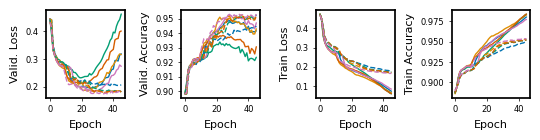

In [5]:
_results = pd.DataFrame(results)
_results = _results[(_results['lr'] == 0.0001)]
_results = _results[(_results['Epoch'] <= 45)]

keys = ['Valid. Loss', 'Valid. Accuracy', 'Train Loss', 'Train Accuracy']
fig, axes = plt.subplots(1, 4, figsize=(5.5, 1.5))
for idx, key in enumerate(keys):
    # Plot dropout=0.0
    sns.lineplot(
        data=_results[_results['dropout'] == 0.0], 
        x='Epoch', 
        y=key,
        hue='seed',
        legend=False,
        palette=sns.color_palette(),
        ax=axes[idx],
    )
    # Plot dropout=0.2
    sns.lineplot(
        data=_results[_results['dropout'] == 0.2], 
        x='Epoch', 
        y=key,
        hue='seed',
        linestyle='--',
        legend=False,
        palette=sns.color_palette(),
        ax=axes[idx]
    )
    
    # Set y-ticks for Valid. Accuracy
    if key == 'Valid. Accuracy':
        axes[idx].set_yticks(np.arange(0.90, 0.96, 0.01))
        
    axes[idx].set_xlabel('Epoch', fontsize=8)
    axes[idx].set_ylabel(key, fontsize=8)
    axes[idx].tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig('figs_app/B_8B.png', dpi=300, transparent=True)
plt.savefig('figs_app/B_8B.pdf', dpi=300, transparent=True)
plt.show()

### LR = 1E-5

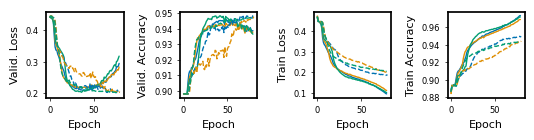

In [6]:
_results = pd.DataFrame(results)
_results = _results[(_results['lr'] == 0.00001)]
_results = _results[(_results['Epoch'] <= 80)]

keys = ['Valid. Loss', 'Valid. Accuracy', 'Train Loss', 'Train Accuracy']
fig, axes = plt.subplots(1, 4, figsize=(5.5, 1.5))
for idx, key in enumerate(keys):
    # Plot dropout=0.0
    sns.lineplot(
        data=_results[_results['dropout'] == 0.0], 
        x='Epoch', 
        y=key,
        hue='seed',
        legend=False,
        palette=sns.color_palette(),
        ax=axes[idx],
    )
    # Plot dropout=0.2
    sns.lineplot(
        data=_results[_results['dropout'] == 0.2], 
        x='Epoch', 
        y=key,
        hue='seed',
        linestyle='--',
        legend=False,
        palette=sns.color_palette(),
        ax=axes[idx]
    )
    
    # Set y-ticks for Valid. Accuracy
    if key == 'Valid. Accuracy':
        axes[idx].set_yticks(np.arange(0.90, 0.96, 0.01))
        
    axes[idx].set_xlabel('Epoch', fontsize=8)
    axes[idx].set_ylabel(key, fontsize=8)
    axes[idx].tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig('figs_app/B_8C.png', dpi=300, transparent=True)
plt.savefig('figs_app/B_8C.pdf', dpi=300, transparent=True)
plt.show()

# Tree Maze Longer Training

In [15]:
project_dir = 'tree_maze_more_training'
model_dir = f'/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/{project_dir}/cntree_layers7_bprob0.9_corr0.25_state_dim10_envs300000_H800_explore/models/'
model_basename = 'transformer_end_query_embd512_layer3_head4'

In [16]:
val_loss_results = {}
val_accuracy_results = {}
train_loss_results = {}
train_accuracy_results = {}
all_results = [val_loss_results, val_accuracy_results, train_loss_results, train_accuracy_results]
result_keys = ['Valid. Loss', 'Valid. Accuracy', 'Train Loss', 'Train Accuracy']
result_fmt_keys = ['val_loss', 'val_accuracy', 'train_loss', 'train_accuracy']

for r, specific_key in zip(
        all_results,
        result_keys
    ):
    for k in ['Epoch', 'lr', 'dropout', 'seed']:
        r[k] = []
    r[specific_key] = []

for f in os.listdir(model_dir):
    if not f.startswith(model_basename):
        continue
    model_info = parse_model_string(f)
    dir_path = os.path.join(model_dir, f)
    with open(os.path.join(dir_path, 'run_info.json'), 'r') as f:
        run_info = json.load(f)

    run_name = run_info['run_name']
    run_id = run_info['run_id']  # or run_info['name'] depending on the file structure

    # Initialize the API and get the run
    api = wandb.Api()
    run = api.run(f"chingfang17-harvard-university/{project_dir}/{run_id}")

    summary = run.summary
    history = run.history()
    epoch = np.array(history['epoch'])

    if history['val_loss'][np.isnan(history['val_loss']) == False].min() < 1e-3:  # There was a mistake in old training runs where the already normalized loss was further divided by batch size
        history['val_loss'] = history['val_loss'] * model_info['batch_size']
        history['train_loss'] = history['train_loss'] * model_info['batch_size']

    for r, r_key, r_fmt_key in zip(
            all_results,
            result_keys,
            result_fmt_keys
        ):

        specific_results = np.array(history[r_fmt_key])
        aligned_epoch = epoch[np.isnan(specific_results) != True]
        r['Epoch'].extend(aligned_epoch.tolist())
        r[r_key].extend(specific_results[np.isnan(specific_results) != True].tolist())
        r['lr'].extend([model_info['learning_rate']] * len(aligned_epoch))
        r['dropout'].extend([model_info['dropout']] * len(aligned_epoch))
        r['seed'].extend([model_info['init_seed']] * len(aligned_epoch))


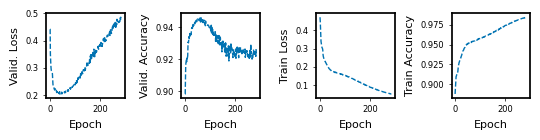

In [18]:
fig, axes = plt.subplots(1, 4, figsize=(5.5, 1.5))
for idx in range(len(all_results)):
    r = all_results[idx]
    r_key = result_keys[idx]
    _r = pd.DataFrame(r)
    sns.lineplot(
        data=_r[_r['dropout'] == 0.2], 
        x='Epoch', 
        y=r_key,
        hue='seed',
        linestyle='--',
        legend=False,
        palette=sns.color_palette(),
        ax=axes[idx]
    )
    
    # Set y-ticks for Valid. Accuracy
    if key == 'Valid. Accuracy':
        axes[idx].set_yticks(np.arange(0.90, 0.96, 0.01))
        
    axes[idx].set_xlabel('Epoch', fontsize=8)
    axes[idx].set_ylabel(r_key, fontsize=8)
    axes[idx].tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig('figs_app/B_8D.png', dpi=300, transparent=True)
plt.savefig('figs_app/B_8D.pdf', dpi=300, transparent=True)
plt.show()

# Tree Maze Big Pretraining Dataset

In [19]:
project_dir = 'tree_maze_big_pretraining'
model_dir = f'/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/{project_dir}/cntree_layers7_bprob0.9_corr0.25_state_dim10_envs600000_H800_explore/models/'
model_basename = 'transformer_end_query_embd512_layer3_head4'

In [20]:
val_loss_results = {}
val_accuracy_results = {}
train_loss_results = {}
train_accuracy_results = {}
all_results = [val_loss_results, val_accuracy_results, train_loss_results, train_accuracy_results]
result_keys = ['Valid. Loss', 'Valid. Accuracy', 'Train Loss', 'Train Accuracy']
result_fmt_keys = ['val_loss', 'val_accuracy', 'train_loss', 'train_accuracy']

for r, specific_key in zip(
        all_results,
        result_keys
    ):
    for k in ['Epoch', 'lr', 'dropout', 'seed']:
        r[k] = []
    r[specific_key] = []

for f in os.listdir(model_dir):
    if not f.startswith(model_basename):
        continue
    model_info = parse_model_string(f)
    dir_path = os.path.join(model_dir, f)
    with open(os.path.join(dir_path, 'run_info.json'), 'r') as f:
        run_info = json.load(f)

    run_name = run_info['run_name']
    run_id = run_info['run_id']  # or run_info['name'] depending on the file structure

    # Initialize the API and get the run
    api = wandb.Api()
    run = api.run(f"chingfang17-harvard-university/{project_dir}/{run_id}")

    summary = run.summary
    history = run.history()
    epoch = np.array(history['epoch'])

    if history['val_loss'][np.isnan(history['val_loss']) == False].min() < 1e-3:  # There was a mistake in old training runs where the already normalized loss was further divided by batch size
        history['val_loss'] = history['val_loss'] * model_info['batch_size']
        history['train_loss'] = history['train_loss'] * model_info['batch_size']

    for r, r_key, r_fmt_key in zip(
            all_results,
            result_keys,
            result_fmt_keys
        ):

        specific_results = np.array(history[r_fmt_key])
        aligned_epoch = epoch[np.isnan(specific_results) != True]
        r['Epoch'].extend(aligned_epoch.tolist())
        r[r_key].extend(specific_results[np.isnan(specific_results) != True].tolist())
        r['lr'].extend([model_info['learning_rate']] * len(aligned_epoch))
        r['dropout'].extend([model_info['dropout']] * len(aligned_epoch))
        r['seed'].extend([model_info['init_seed']] * len(aligned_epoch))


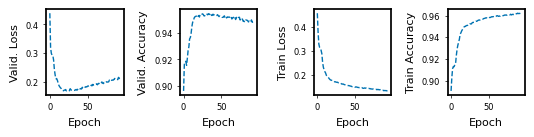

In [21]:
fig, axes = plt.subplots(1, 4, figsize=(5.5, 1.5))
for idx in range(len(all_results)):
    r = all_results[idx]
    r_key = result_keys[idx]
    _r = pd.DataFrame(r)
    sns.lineplot(
        data=_r[_r['dropout'] == 0.2], 
        x='Epoch', 
        y=r_key,
        hue='seed',
        linestyle='--',
        legend=False,
        palette=sns.color_palette(),
        ax=axes[idx]
    )
    
    # Set y-ticks for Valid. Accuracy
    if key == 'Valid. Accuracy':
        axes[idx].set_yticks(np.arange(0.90, 0.96, 0.01))
        
    axes[idx].set_xlabel('Epoch', fontsize=8)
    axes[idx].set_ylabel(r_key, fontsize=8)
    axes[idx].tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig('figs_app/B_8E.png', dpi=300, transparent=True)
plt.savefig('figs_app/B_8E.pdf', dpi=300, transparent=True)
plt.show()

# Tree Maze Uncorrelated Stimuli

In [22]:
project_dir = 'tree_maze'
model_dir = f'/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/{project_dir}/cntree_layers7_bprob0.9_corr0.0_state_dim10_envs300000_H800_explore/models/'
model_basename = 'transformer_end_query_embd512_layer3_head4'

In [23]:
val_loss_results = {}
val_accuracy_results = {}
train_loss_results = {}
train_accuracy_results = {}
all_results = [val_loss_results, val_accuracy_results, train_loss_results, train_accuracy_results]
result_keys = ['Valid. Loss', 'Valid. Accuracy', 'Train Loss', 'Train Accuracy']
result_fmt_keys = ['val_loss', 'val_accuracy', 'train_loss', 'train_accuracy']

for r, specific_key in zip(
        all_results,
        result_keys
    ):
    for k in ['Epoch', 'lr', 'dropout', 'seed', 'dim', 'layers', 'batch_size']:
        r[k] = []
    r[specific_key] = []

for f in os.listdir(model_dir):
    if not f.startswith(model_basename):
        continue
    model_info = parse_model_string(f)
    dir_path = os.path.join(model_dir, f)
    with open(os.path.join(dir_path, 'run_info.json'), 'r') as f:
        run_info = json.load(f)

    run_name = run_info['run_name']
    run_id = run_info['run_id']  # or run_info['name'] depending on the file structure

    # Initialize the API and get the run
    api = wandb.Api()
    try:
        run = api.run(f"chingfang17-harvard-university/{project_dir}/{run_id}")
    except:
        continue

    summary = run.summary
    history = run.history()
    epoch = np.array(history['epoch'])

    if history['val_loss'][np.isnan(history['val_loss']) == False].min() < 1e-3:  # There was a mistake in old training runs where the already normalized loss was further divided by batch size
        history['val_loss'] = history['val_loss'] * model_info['batch_size']
        history['train_loss'] = history['train_loss'] * model_info['batch_size']

    for r, r_key, r_fmt_key in zip(
            all_results,
            result_keys,
            result_fmt_keys
        ):

        specific_results = np.array(history[r_fmt_key])
        aligned_epoch = epoch[np.isnan(specific_results) != True]
        r['Epoch'].extend(aligned_epoch.tolist())
        r[r_key].extend(specific_results[np.isnan(specific_results) != True].tolist())
        r['lr'].extend([model_info['learning_rate']] * len(aligned_epoch))
        r['dropout'].extend([model_info['dropout']] * len(aligned_epoch))
        r['seed'].extend([model_info['init_seed']] * len(aligned_epoch))
        r['dim'].extend([model_info['embedding_dim']] * len(aligned_epoch))
        r['layers'].extend([model_info['num_layers']] * len(aligned_epoch))
        r['batch_size'].extend([model_info['batch_size']] * len(aligned_epoch))


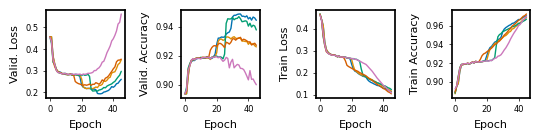

In [24]:
# 6-layer models, dim = 512
fig, axes = plt.subplots(1, 4, figsize=(5.5, 1.5))
for idx in range(len(all_results)):
    r = all_results[idx]
    r_key = result_keys[idx]
    _r = pd.DataFrame(r)
    _r = _r[_r['layers'] == 3]
    _r = _r[_r['Epoch'] <= 45]
    _r = _r[_r['lr'] == 0.0001]
    sns.lineplot(
        data=_r[_r['dropout'] == 0.], 
        x='Epoch', 
        y=r_key,
        hue='seed',
        legend=False,
        palette=sns.color_palette(),
        ax=axes[idx]
    )
    sns.lineplot(
        data=_r[_r['dropout'] == 0.2],
        x='Epoch',
        y=r_key,
        hue='seed',
        linestyle='--',
        legend=False,
        palette=sns.color_palette(),
        ax=axes[idx]
    )    
    # Set y-ticks for Valid. Accuracy
    if key == 'Valid. Accuracy':
        axes[idx].set_yticks(np.arange(0.90, 0.96, 0.01))
        
    axes[idx].set_xlabel('Epoch', fontsize=8)
    axes[idx].set_ylabel(r_key, fontsize=8)
    axes[idx].tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig('figs_app/B_8F.png', dpi=300, transparent=True)
plt.savefig('figs_app/B_8F.pdf', dpi=300, transparent=True)
plt.show()

# Tree Maze Bigger Models

In [25]:
project_dir = 'tree_maze_bigger_models'
model_dir = f'/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/{project_dir}/cntree_layers7_bprob0.9_corr0.25_state_dim10_envs300000_H800_explore/models/'
model_basename = 'transformer_end_query'

In [26]:
val_loss_results = {}
val_accuracy_results = {}
train_loss_results = {}
train_accuracy_results = {}
all_results = [val_loss_results, val_accuracy_results, train_loss_results, train_accuracy_results]
result_keys = ['Valid. Loss', 'Valid. Accuracy', 'Train Loss', 'Train Accuracy']
result_fmt_keys = ['val_loss', 'val_accuracy', 'train_loss', 'train_accuracy']

for r, specific_key in zip(
        all_results,
        result_keys
    ):
    for k in ['Epoch', 'lr', 'dropout', 'seed', 'dim', 'layers', 'batch_size']:
        r[k] = []
    r[specific_key] = []

for f in os.listdir(model_dir):
    if not f.startswith(model_basename):
        continue
    model_info = parse_model_string(f)
    dir_path = os.path.join(model_dir, f)
    with open(os.path.join(dir_path, 'run_info.json'), 'r') as f:
        run_info = json.load(f)

    run_name = run_info['run_name']
    run_id = run_info['run_id']  # or run_info['name'] depending on the file structure

    # Initialize the API and get the run
    api = wandb.Api()
    try:
        run = api.run(f"chingfang17-harvard-university/{project_dir}/{run_id}")
    except:
        continue

    summary = run.summary
    history = run.history()
    epoch = np.array(history['epoch'])

    if history['val_loss'][np.isnan(history['val_loss']) == False].min() < 1e-3:  # There was a mistake in old training runs where the already normalized loss was further divided by batch size
        history['val_loss'] = history['val_loss'] * model_info['batch_size']
        history['train_loss'] = history['train_loss'] * model_info['batch_size']

    for r, r_key, r_fmt_key in zip(
            all_results,
            result_keys,
            result_fmt_keys
        ):

        specific_results = np.array(history[r_fmt_key])
        aligned_epoch = epoch[np.isnan(specific_results) != True]
        r['Epoch'].extend(aligned_epoch.tolist())
        r[r_key].extend(specific_results[np.isnan(specific_results) != True].tolist())
        r['lr'].extend([model_info['learning_rate']] * len(aligned_epoch))
        r['dropout'].extend([model_info['dropout']] * len(aligned_epoch))
        r['seed'].extend([model_info['init_seed']] * len(aligned_epoch))
        r['dim'].extend([model_info['embedding_dim']] * len(aligned_epoch))
        r['layers'].extend([model_info['num_layers']] * len(aligned_epoch))
        r['batch_size'].extend([model_info['batch_size']] * len(aligned_epoch))


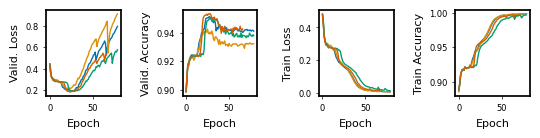

In [27]:
# 3-layer models, dim = 1024
fig, axes = plt.subplots(1, 4, figsize=(5.5, 1.5))
for idx in range(len(all_results)):
    r = all_results[idx]
    r_key = result_keys[idx]
    _r = pd.DataFrame(r)
    _r = _r[_r['layers'] == 3]
    sns.lineplot(
        data=_r[_r['dropout'] == 0.], 
        x='Epoch', 
        y=r_key,
        hue='seed',
        legend=False,
        palette=sns.color_palette(),
        ax=axes[idx]
    )
    
    # Set y-ticks for Valid. Accuracy
    if key == 'Valid. Accuracy':
        axes[idx].set_yticks(np.arange(0.90, 0.96, 0.01))
        
    axes[idx].set_xlabel('Epoch', fontsize=8)
    axes[idx].set_ylabel(r_key, fontsize=8)
    axes[idx].tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig('figs_app/B_9A.png', dpi=300, transparent=True)
plt.savefig('figs_app/B_9A.pdf', dpi=300, transparent=True)
plt.show()

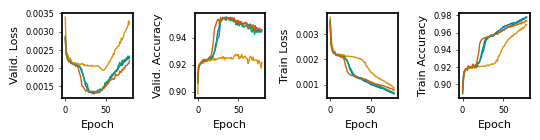

In [28]:
# 4-layer model, dim = 512
fig, axes = plt.subplots(1, 4, figsize=(5.5, 1.5))
for idx in range(len(all_results)):
    r = all_results[idx]
    r_key = result_keys[idx]
    _r = pd.DataFrame(r)
    _r = _r[_r['layers'] == 4]
    _r = _r[_r['batch_size'] == 128]
    _r = _r[_r['lr'] == 0.0001]
    sns.lineplot(
        data=_r[_r['dropout'] == 0.], 
        x='Epoch', 
        y=r_key,
        hue='seed',
        legend=False,
        palette=sns.color_palette(),
        ax=axes[idx]
    )
    sns.lineplot(
        data=_r[_r['dropout'] == 0.2],
        x='Epoch',
        y=r_key,
        hue='seed',
        linestyle='--',
        legend=False,
        palette=sns.color_palette(),
        ax=axes[idx]
    )    
    # Set y-ticks for Valid. Accuracy
    if key == 'Valid. Accuracy':
        axes[idx].set_yticks(np.arange(0.90, 0.96, 0.01))
        
    axes[idx].set_xlabel('Epoch', fontsize=8)
    axes[idx].set_ylabel(r_key, fontsize=8)
    axes[idx].tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig('figs_app/B_9B.png', dpi=300, transparent=True)
plt.savefig('figs_app/B_9B.pdf', dpi=300, transparent=True)
plt.show()

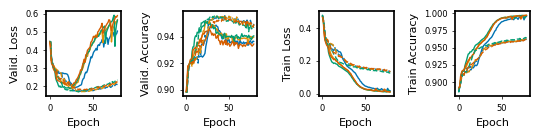

In [29]:
# 6-layer models, dim = 512
fig, axes = plt.subplots(1, 4, figsize=(5.5, 1.5))
for idx in range(len(all_results)):
    r = all_results[idx]
    r_key = result_keys[idx]
    _r = pd.DataFrame(r)
    _r = _r[_r['layers'] == 6]
    _r = _r[_r['batch_size'] == 256]
    _r = _r[_r['lr'] == 0.0001]
    sns.lineplot(
        data=_r[_r['dropout'] == 0.], 
        x='Epoch', 
        y=r_key,
        hue='seed',
        legend=False,
        palette=sns.color_palette(),
        ax=axes[idx]
    )
    sns.lineplot(
        data=_r[_r['dropout'] == 0.2],
        x='Epoch',
        y=r_key,
        hue='seed',
        linestyle='--',
        legend=False,
        palette=sns.color_palette(),
        ax=axes[idx]
    )    
    # Set y-ticks for Valid. Accuracy
    if key == 'Valid. Accuracy':
        axes[idx].set_yticks(np.arange(0.90, 0.96, 0.01))
        
    axes[idx].set_xlabel('Epoch', fontsize=8)
    axes[idx].set_ylabel(r_key, fontsize=8)
    axes[idx].tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig('figs_app/B_9C.png', dpi=300, transparent=True)
plt.savefig('figs_app/B_9C.pdf', dpi=300, transparent=True)
plt.show()

# Darkroom

In [30]:
project_dir = 'darkroom_simple'
model_dir = f'/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/{project_dir}/darkroom_dim5_corr0.25_state_dim10_envs900000_H200_explore/models/'
model_basename = 'transformer_end_query_embd512_layer3_head4'

In [31]:
val_loss_results = {}
val_accuracy_results = {}
train_loss_results = {}
train_accuracy_results = {}
all_results = [val_loss_results, val_accuracy_results, train_loss_results, train_accuracy_results]
result_keys = ['Valid. Loss', 'Valid. Accuracy', 'Train Loss', 'Train Accuracy']
result_fmt_keys = ['val_loss', 'val_accuracy', 'train_loss', 'train_accuracy']

for r, specific_key in zip(
        all_results,
        result_keys
    ):
    for k in ['Epoch', 'lr', 'dropout', 'seed', 'dim', 'layers', 'batch_size']:
        r[k] = []
    r[specific_key] = []

for f in os.listdir(model_dir):
    if not f.startswith(model_basename):
        continue
    model_info = parse_model_string(f)
    dir_path = os.path.join(model_dir, f)
    with open(os.path.join(dir_path, 'run_info.json'), 'r') as f:
        run_info = json.load(f)

    run_name = run_info['run_name']
    run_id = run_info['run_id']  # or run_info['name'] depending on the file structure

    # Initialize the API and get the run
    api = wandb.Api()
    try:
        run = api.run(f"chingfang17-harvard-university/{project_dir}/{run_id}")
    except:
        continue

    summary = run.summary
    history = run.history()
    epoch = np.array(history['epoch'])

    if history['val_loss'][np.isnan(history['val_loss']) == False].min() < 1e-3:  # There was a mistake in old training runs where the already normalized loss was further divided by batch size
        history['val_loss'] = history['val_loss'] * model_info['batch_size']
        history['train_loss'] = history['train_loss'] * model_info['batch_size']

    for r, r_key, r_fmt_key in zip(
            all_results,
            result_keys,
            result_fmt_keys
        ):

        specific_results = np.array(history[r_fmt_key])
        aligned_epoch = epoch[np.isnan(specific_results) != True]
        r['Epoch'].extend(aligned_epoch.tolist())
        r[r_key].extend(specific_results[np.isnan(specific_results) != True].tolist())
        r['lr'].extend([model_info['learning_rate']] * len(aligned_epoch))
        r['dropout'].extend([model_info['dropout']] * len(aligned_epoch))
        r['seed'].extend([model_info['init_seed']] * len(aligned_epoch))
        r['dim'].extend([model_info['embedding_dim']] * len(aligned_epoch))
        r['layers'].extend([model_info['num_layers']] * len(aligned_epoch))
        r['batch_size'].extend([model_info['batch_size']] * len(aligned_epoch))


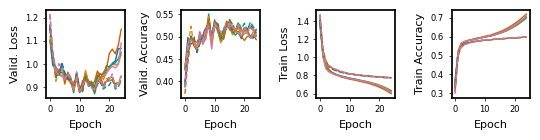

In [32]:
# Lower learning rate
fig, axes = plt.subplots(1, 4, figsize=(5.5, 1.5))
for idx in range(len(all_results)):
    r = all_results[idx]
    r_key = result_keys[idx]
    _r = pd.DataFrame(r)
    sns.lineplot(
        data=_r[_r['dropout'] == 0.], 
        x='Epoch', 
        y=r_key,
        hue='seed',
        legend=False,
        palette=sns.color_palette(),
        ax=axes[idx]
    )
    sns.lineplot(
        data=_r[_r['dropout'] == 0.2],
        x='Epoch',
        y=r_key,
        hue='seed',
        linestyle='--',
        legend=False,
        palette=sns.color_palette(),
        ax=axes[idx]
    )    
    # Set y-ticks for Valid. Accuracy
    if key == 'Valid. Accuracy':
        axes[idx].set_yticks(np.arange(0.90, 0.96, 0.01))
        
    axes[idx].set_xlabel('Epoch', fontsize=8)
    axes[idx].set_ylabel(r_key, fontsize=8)
    axes[idx].tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig('figs_app/B_8A.png', dpi=300, transparent=True)
plt.savefig('figs_app/B_8A.pdf', dpi=300, transparent=True)
plt.show()